In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
import ot.plot
from tqdm import trange

In [9]:
import os
import sys
sys.path.append('../code/')
from SWGG import SWGG_GG,SWGG_CP,get_SWGG_smooth
from utils import random_slice
from generate_data import make_data

In [10]:
if torch.cuda.is_available():
    device='cuda'
    dtype = torch.cuda.DoubleTensor
else:
    device='cpu'
    dtype=torch.DoubleTensor
print(device)

device='cpu'
dtype=torch.DoubleTensor
torch.set_default_tensor_type(dtype)

cuda


In [11]:
d=10
n=200

mu_s=np.ones(d)
cov_s=np.array([13,1,.3,1,2,1,3,2,.4,1])
cov_s = cov_s * np.eye(d)

mu_t=-np.ones(d)
cov_t=np.array([2,1,15,1,.2,.8,3,2,1,.4])
cov_t = cov_t * np.eye(d)
        
xs = np.random.multivariate_normal(mu_s, cov_s, n)
xt = np.random.multivariate_normal(mu_t, cov_t, n)

X = torch.from_numpy(xs).to(device)
Y = torch.from_numpy(xt).to(device)
X=X.float()
Y=Y.float()

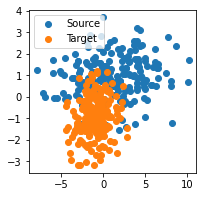

In [12]:
pl.figure(figsize=(3,3))
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
pl.legend(loc=2)

# $W^2_2$

In [13]:
ns=X.shape[0]
nt=Y.shape[0]
a, b = torch.ones((ns,))/nt, torch.ones((nt,))/nt
#The exact Wasserstein distance
C=ot.dist(X,Y)#,metric='euclidean')
print('W = ',ot.emd2(a,b,C))

W =  tensor(66.5252)


# $\min SWGG_2^2$

In [16]:
n_proj=30
theta=random_slice(n_proj,d).T.float()

#minS permutation
W=torch.min(SWGG_CP(X,Y,theta)[0])
print('SWGG = ',W)

#minS generalized geodesics
W=torch.min(SWGG_GG(X,Y,theta)[0])
print('SWGG = ',W)


SWGG =  tensor(84.7331, dtype=torch.float32)
SWGG =  tensor(84.7331, dtype=torch.float32)


In [20]:
num_iter=200
lr=1e-1
s=20
std=.5

t,loss_smooth_l,proj_smooth_l = get_SWGG_smooth(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
t.requires_grad=False
theta_optim=t/torch.norm(t)

res_smooth=SWGG_CP(X,Y,theta_optim.reshape(d,1))[0]
print('minS with selected theta',res_smooth)

100%|████████████████████████| 200/200 [00:00<00:00, 541.26it/s, loss = 107.661]


minS with selected theta tensor([86.9217], dtype=torch.float32)


Text(0.5, 1.0, 'Choosen direction')

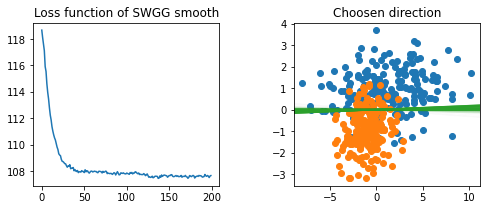

In [21]:
pl.figure(figsize=(8,3))
grid = pl.GridSpec(1, 2, wspace=0.4, hspace=0.3)

pl.subplot(grid[0, 0])
pl.plot(loss_smooth_l)
pl.title('Loss function of SWGG smooth')

pl.subplot(grid[0, 1])
pl.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
pl.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
for i in range(num_iter):
    pl.axline((0,0), list(proj_smooth_l[i,0:2]), color='C2',alpha=(i/num_iter)**10)
pl.title('Choosen direction')